# HABSlib 101

In this first notebook, we will move our first steps into the HABSlib client library for the HABS BrainOS API.    
This library allows you to record, store safely, and analyze EEG data, using the HABS BrainOS platform.

In this first hands-on lesson, we will look at installation, handshake, using the HABS generator of dummy EEG signals, and perform one simple analysis.      
Please, refer to the documentation of [HABSlib]() for further details.

In [1]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb

## Login
In order to use the HABS API, you need to create a free account on habs.ai/developer.    
This provides you with the **developer IP address** you can use, and a **user ID**, which you will use for all your interaction with the APIs.

The first thing to do to start a session with the HABS BrainOS is to handshake.

In [2]:
hb.handshake(base_url="http://74.249.61.11", user_id='666c0158fcbfd9a830399121')


       HUMAN        AUGMENTED        BRAIN         SYSTEMS     
   ----------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░  
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░  
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ----------------------------------------------------------- 
   version: 0.1.33

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Get user data
You can query the user data stored on the server

In [3]:
user_data = hb.get_user_by_id(user_id='666c0158fcbfd9a830399121')
print(user_data)

User found.
{'_id': {'$oid': '666c0158fcbfd9a830399121'}, 'user_data': {'first_name': 'Domenico', 'last_name': 'Guarino', 'role': 'Admin', 'group': 'HABS', 'email': 'domenico@habs.ai', 'age': 50, 'weight': 89, 'gender': 'M', 'devices': ['MuseS-88D1']}}


## Acquire data and send
For this tutorial, we use the synthetic board included in the HABSlib, which allows you to define:
- number of EEG channels ('eeg_channels')
- sampling frequency of the channels ('sampling_rate')
- level of noise ('noise' between 0, no noise, and 1)
- probability of observing a generic artifact ('artifacts')
- type of envelope modulation of the EEG (currently 'sinusoidal', at 0.1Hz, or 'random', with mean=0 var=1)
- amplitude in each of the frequency bands ('delta_amp', 'theta_amp', ...)
- some 'preset' amplitude contents for different states ('focus', 'alert', 'relaxed', 'drowsy')
- the presets can be put in a sequence to vary the signal over time
- correlation can be introduced between nearby channels ('correlation_strength')
- given that the PSD of EEG often follows a power-law relationship, we can provide its slope

As you can see, there are quite a number of options to play with even without an actual EEG device ;)

**IMPORTANT NOTE**: this EEG simulator takes the same amount of time of a user recording 20 sec during a session. You should see this output:
```
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....                              <<<<---- these points!
Stopping data streaming...
Releasing session...
```

In [4]:
from datetime import datetime

session_id = hb.acquire_send_raw(
    user_id='666c0158fcbfd9a830399121', 
    date=datetime.today().strftime('%Y-%m-%d'), 
    board="SYNTHETIC", 
    extra={
        "eeg_channels": 16,
        "sampling_rate": 250,
        "noise": 1,
        "artifacts": 0.001,
        "modulation_type": 'random',
        "preset": 'focus', # None # 
        "sequence": None, # [("focus", 20), ("relaxed", 20)],
        "correlation_strength": 0.5
    },
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)
print("this session:", session_id)

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=6697fabe8ec163be17147081 

{'user_id': '666c0158fcbfd9a830399121', 'session_date': '2024-07-17', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...
this session: 6697fabe8ec163be17147081


## Take your data
Now copy the session_id of the session you just created and paste it 

In [5]:
import numpy as np

results = hb.get_data_by_session(user_id='666c0158fcbfd9a830399121', session_id='6697fabe8ec163be17147081')
data = np.array(results)
print(data.shape)
print(data) 

Retrieved data successfully.
(16, 5000)
[[ 1.34707035e-01 -3.06059355e+00  5.00303820e-01 ... -2.04124595e+00
  -1.18329894e+00 -1.98489590e-01]
 [-3.17780359e-01 -1.71937662e-01  1.83401363e-01 ...  3.31409556e-01
   1.55375029e+00  7.48642659e-01]
 [-1.48875205e+00 -8.53246348e-02 -1.33342036e+00 ...  3.76547817e-01
  -1.06500108e-01 -5.16933793e-01]
 ...
 [-7.39511387e-01  4.51888620e-01  2.25355736e+00 ...  1.21039523e+00
  -7.47328616e-02  8.40595693e-01]
 [-6.79410534e-01 -1.11764795e+00  3.10202687e+00 ... -1.57912958e-01
  -7.45542517e-01 -9.87432562e-01]
 [ 2.69277634e+02  2.84788343e+02 -7.07838993e+01 ...  1.41033896e+02
   2.49603690e+02 -1.20280953e+01]]


### Now plot it

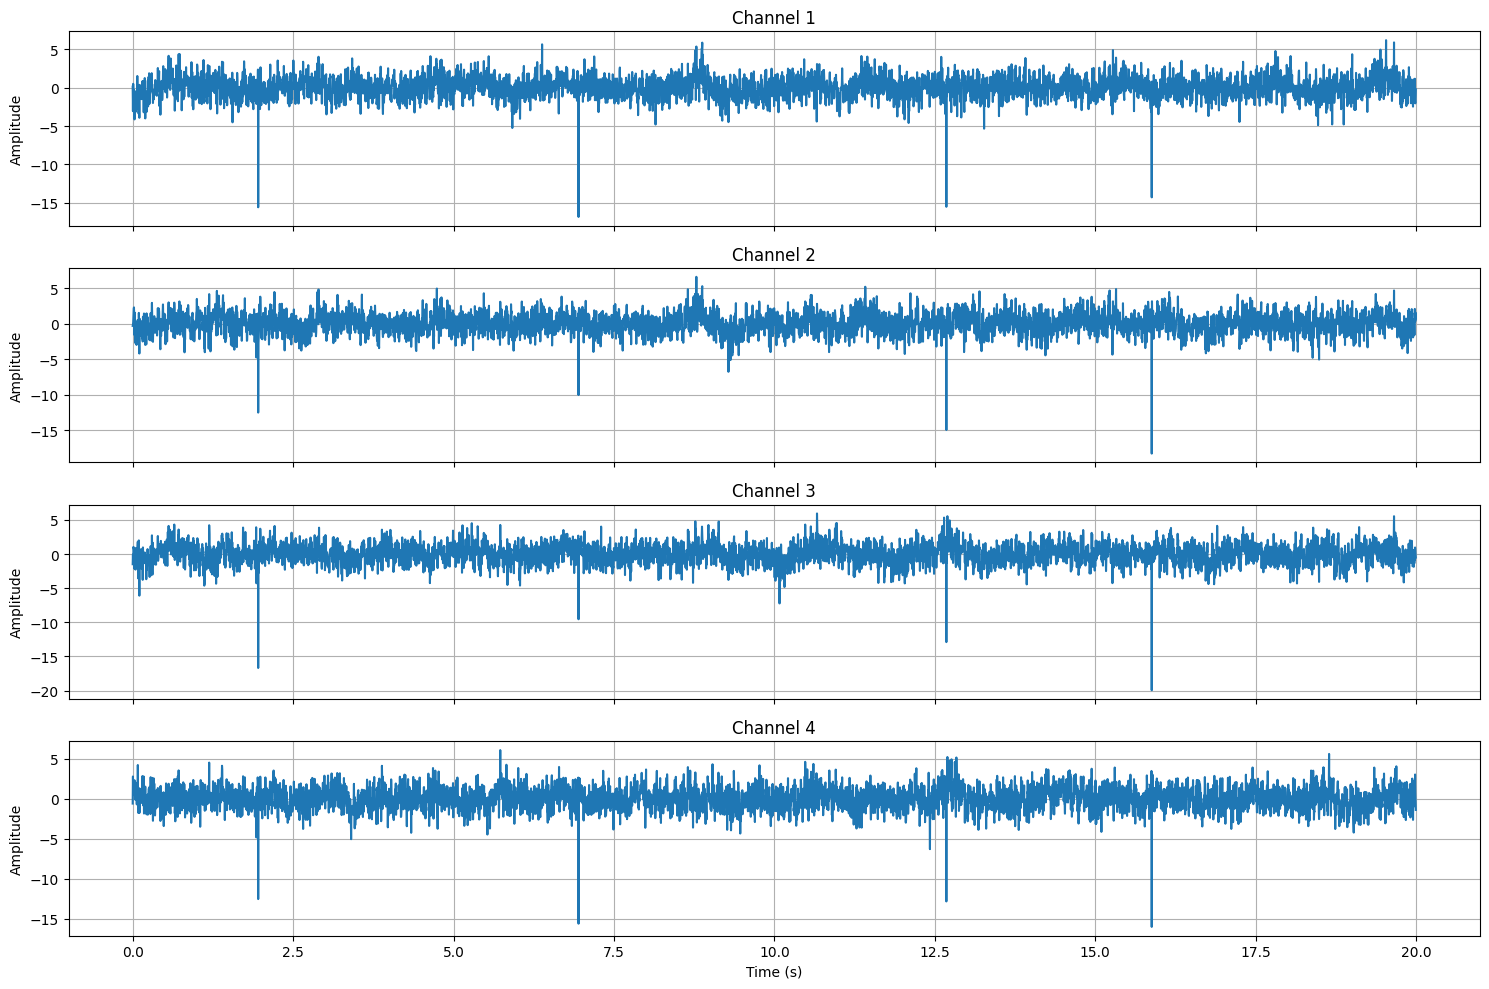

In [6]:
import matplotlib.pyplot as plt

samples_per_second = 250
num_channels=4 # how many you want to plot
    
time = np.arange(data.shape[1]) / samples_per_second
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i, ax in enumerate(axes[:num_channels]):
    ax.plot(time, data[i])
    ax.set_title(f'Channel {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

We passed 'focus' as parameter of the dummy EEG generator. This implies the following amplitude proportions:     
```   
            del  the  alp  bet  gam
'focus':   [0.1, 0.1, 0.5, 0.8, 0.4]
```
Is it what we find in the signal if we perform a PSD?

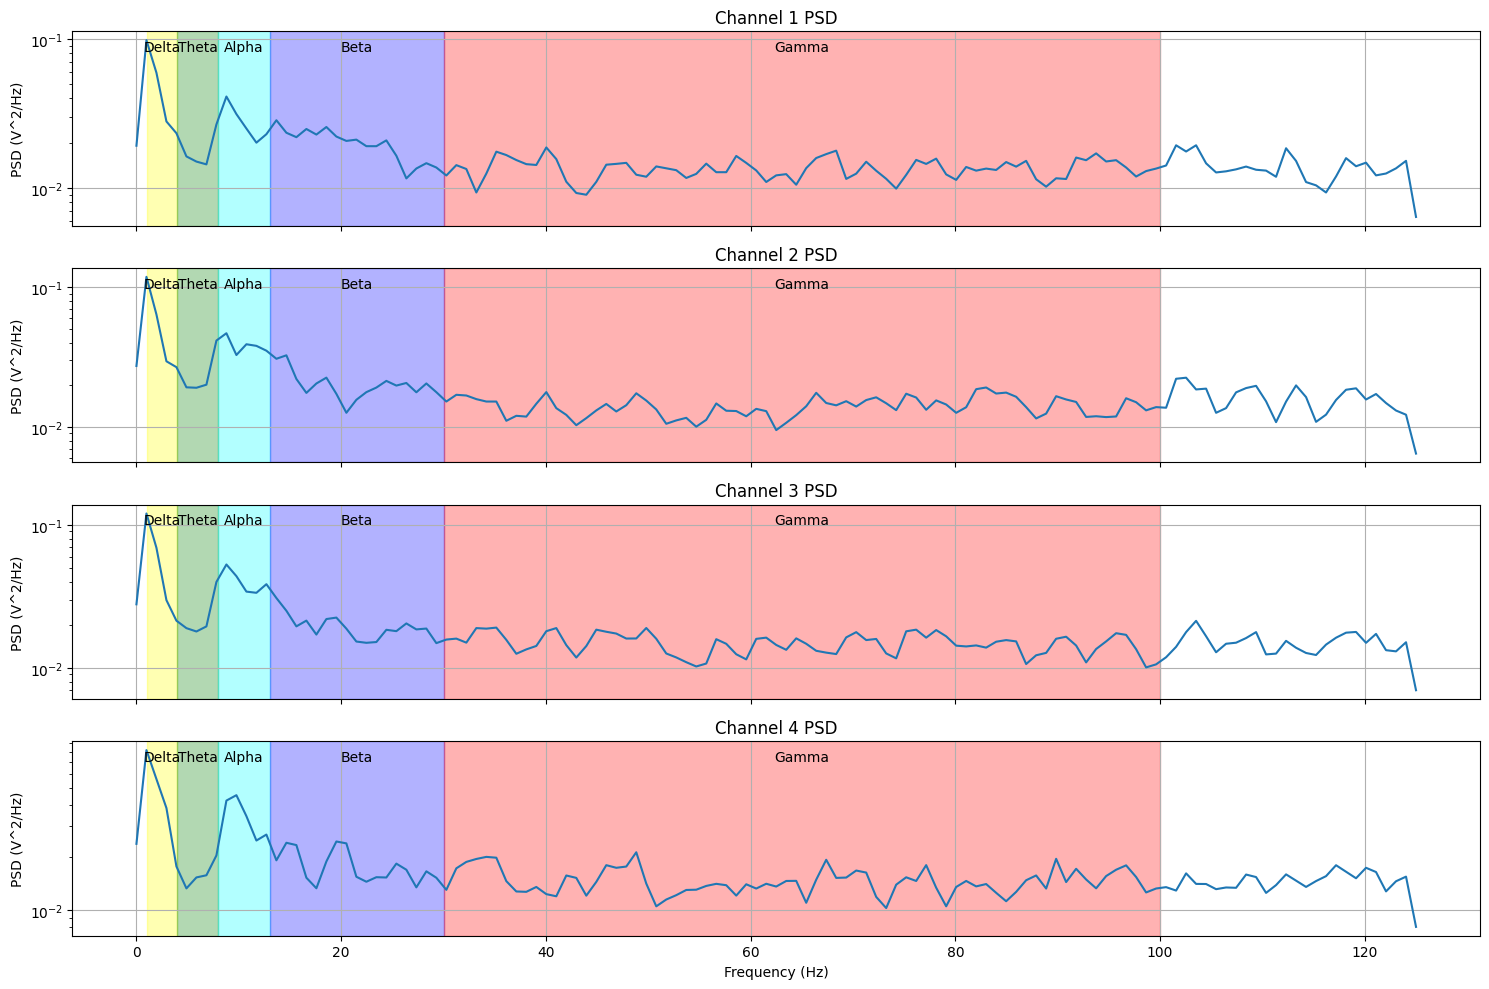

In [7]:
from scipy import signal

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(data[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Congratulations!

You moved your first steps in the HABS BrainOS world!
Move to the [next lesson!](notebooks/HABSlib_101.ipynb)